# Mental Health Sentiment Correlation

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')
%matplotlib inline


## 1) Load dataset

In [5]:
df = pd.read_csv(r"C:\Users\91773\Downloads\Mental_Health_Sentiment_Sample__first_5000_rows_.csv")
df.head(2)

,id,created_at,platform,user_location,text,sentiment_score,sentiment_label,anxiety_score,depression_score,inferred_risk
0,1502,2025-06-29 23:52:50,reddit,"Kolkata,IN","These days I'm so relieved, can't seem to opti...",1.0,positive,-0.084,-0.069,0
1,2587,2024-09-26 13:05:40,twitter,"New York,US","Work has left me good, I feel optimistic and a...",0.0,neutral,0.123,0.206,2


## 2) Data Cleaning & Preprocessing
- Remove URLs, mentions, non-alphabet characters
- Lowercase text
- Create `clean_text` column

In [6]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].head(5)

,text,clean_text
0,"These days I'm so relieved, can't seem to opti...",these days im so relieved cant seem to optimistic
1,"Work has left me good, I feel optimistic and a...",work has left me good i feel optimistic and an...
2,"I've been stressed for weeks, nothing seems to...",ive been stressed for weeks nothing seems to h...
3,Is anyone else feeling depressed? I don't know...,is anyone else feeling depressed i dont know w...
4,Is anyone else feeling stable? I don't know wh...,is anyone else feeling stable i dont know what...


## 3) Sentiment Analysis (Lexicon-based)
We use a simple lexicon (lists of positive and negative words). This is fast and requires no extra libraries.

In [7]:
positive_words = set(['good','happy','love','great','excellent','relief','calm','hope','better','okay','relieved','content','grateful','optimistic','fine','positive','supported','safe'])
negative_words = set(['stress','stressed','anxiety','anxious','depression','depressed','sad','sadness','panic','panicattack','fear','fearful','terrible','awful','hopeless','lonely','helpless','overwhelmed','angry','suicidal','suicide','crying','tired','exhausted','worthless','numb','empty','unhappy','worried','concerned','negative'])

def lexicon_score(text):
    words = text.split()
    score = 0
    for w in words:
        if w in positive_words:
            score += 1
        if w in negative_words:
            score -= 1
    return score

df['lex_score'] = df['clean_text'].apply(lexicon_score)
df['lex_label'] = df['lex_score'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))

df['lex_label'].value_counts()

lex_label
negative    6
positive    2
neutral     2
Name: count, dtype: int64

## 4) Feature Extraction
Create simple features: word_count, keyword_count (mental-health keywords).

In [8]:
mental_words = ['stress','anxiety','depression','sad','fear','panic']
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['keyword_count'] = df['clean_text'].apply(lambda x: sum(w in x.split() for w in mental_words))
df[['clean_text','lex_score','lex_label','word_count','keyword_count']].head()

,clean_text,lex_score,lex_label,word_count,keyword_count
0,these days im so relieved cant seem to optimistic,2,positive,9,0
1,work has left me good i feel optimistic and an...,0,neutral,11,0
2,ive been stressed for weeks nothing seems to h...,-2,negative,10,0
3,is anyone else feeling depressed i dont know w...,-2,negative,12,0
4,is anyone else feeling stable i dont know what...,-1,negative,12,0


## 5) Visualization Dashboard
Simple plots using Matplotlib/Seaborn:
- Sentiment distribution
- Word count vs sentiment
- Keyword count vs sentiment
- Correlation heatmap

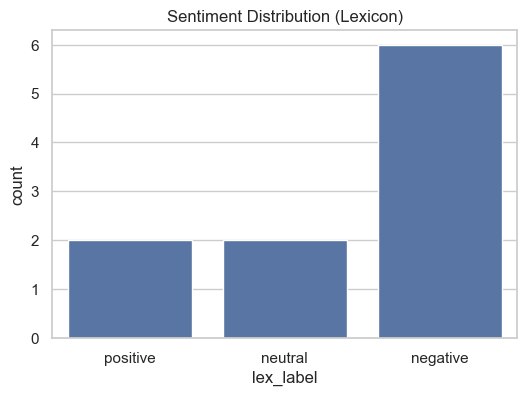

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='lex_label', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment Distribution (Lexicon)')
plt.show()

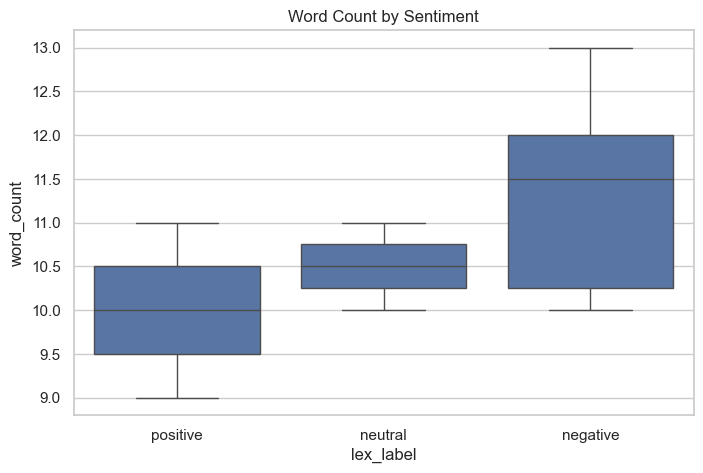

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x='lex_label', y='word_count', data=df, order=['positive','neutral','negative'])
plt.title('Word Count by Sentiment')
plt.show()

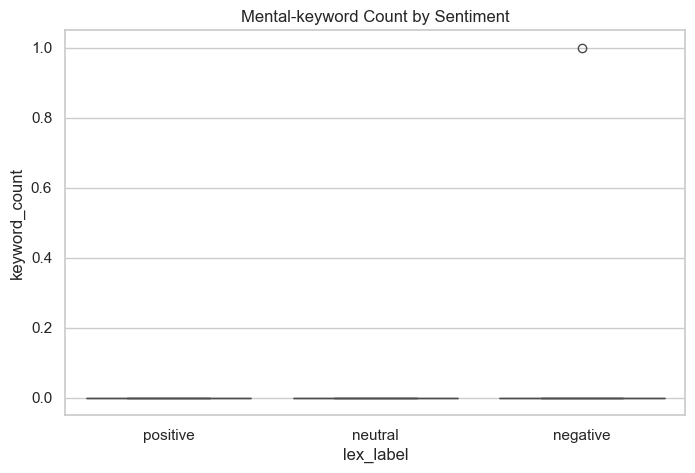

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x='lex_label', y='keyword_count', data=df, order=['positive','neutral','negative'])
plt.title('Mental-keyword Count by Sentiment')
plt.show()

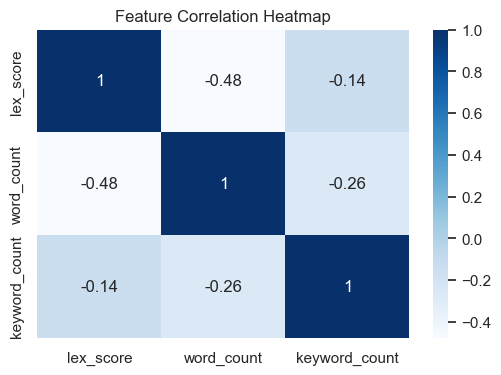

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['lex_score','word_count','keyword_count']].corr(), annot=True, cmap='Blues')
plt.title('Feature Correlation Heatmap')
plt.show()

## 6) ML: TF-IDF + Logistic Regression + Naive Bayes
Use `lex_label` as pseudo-labels if no ground-truth `label` exists. This trains a simple classifier and reports metrics.

In [18]:
import warnings
from sklearn.metrics._classification import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


print(df['lex_label'].value_counts())

# Prepare labels
if 'label' in df.columns:
    y = df['label'].astype(str)
    print('Using ground-truth label column for training.')
else:
    y = df['lex_label']
    print('No ground-truth label found. Using lexicon-derived labels as pseudo-labels.')

X = df['clean_text'].fillna('')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print('Logistic Regression:')
print(classification_report(y_test, y_pred_lr))

lex_label
negative    6
positive    2
neutral     2
Name: count, dtype: int64
No ground-truth label found. Using lexicon-derived labels as pseudo-labels.
Logistic Regression:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       0.0
     neutral       0.00      0.00      0.00       1.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [20]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print('Naive Bayes:')
print(classification_report(y_test, y_pred_nb))

Naive Bayes:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       0.0
     neutral       0.00      0.00      0.00       1.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [21]:
# Save predictions for inspection
out = X_test.to_frame(name='text')
out['true_label'] = y_test.values
out['pred_lr'] = y_pred_lr
out['pred_nb'] = y_pred_nb
out_path = '/mnt/data/ml_test_predictions_notebook.csv'
out.to_csv(out_path, index=False)
print('Saved test predictions to', out_path)

Saved test predictions to /mnt/data/ml_test_predictions_notebook.csv


## 7) Conclusion & Next Steps

- Lexicon is fast but limited; consider labeling a dataset and training supervised models.
- For better accuracy, use transformer models (BERT) or domain-specific lexicons.
- You can expand visualizations or export figures for your report.